## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2021-11-24 15:22:45--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2021-11-24 15:22:45--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc183eaa76e61b4a2504e8b53afc.dl.dropboxusercontent.com/cd/0/inline/Bak2KIIjBEGCUTLDYxe5Ws040AFwHhUEPs0d-WJ1Rg4c_Dw_KDCCfgZMZk5zau8l1DoXnePlbQH2PZj9nvXL8OO0clHG3XBSxJMbwpZpfCw3H4OnIQUUzZXAUYOaf3HFMmLrl4Lqn2eeq0OXXauizJrB/file# [following]
--2021-11-24 15:22:45--  https://uc183eaa76e61b4a2504e8b53afc.dl.dropboxusercontent.com/cd/0/inline/Bak2KIIjBEGCUTLDYxe5Ws040AFwHhUEPs0d-WJ1Rg4c_Dw_KDCCfgZMZk5zau8l1DoXnePlbQH2PZj9nvXL8OO0clHG3XBSxJMbwpZpfCw

 15850K .......... .......... .......... .......... .......... 49% 1,55M 2s
 15900K .......... .......... .......... .......... .......... 49% 54,5M 2s
 15950K .......... .......... .......... .......... .......... 49% 98,5M 2s
 16000K .......... .......... .......... .......... .......... 49%  159M 2s
 16050K .......... .......... .......... .......... .......... 49%  104M 2s
 16100K .......... .......... .......... .......... .......... 49% 98,7M 2s
 16150K .......... .......... .......... .......... .......... 49% 30,5M 2s
 16200K .......... .......... .......... .......... .......... 50% 44,2M 2s
 16250K .......... .......... .......... .......... .......... 50%  157M 2s
 16300K .......... .......... .......... .......... .......... 50%  161M 2s
 16350K .......... .......... .......... .......... .......... 50% 81,3M 2s
 16400K .......... .......... .......... .......... .......... 50% 27,9M 2s
 16450K .......... .......... .......... .......... .......... 50% 23,1M 2s
 16500K ....

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [43]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [44]:
file_name="C:\\Users\\Walter\\LaboratoryOfComputationalPhysics_Y4\\~\\data\\data_000637.txt.2"
df=pd.read_csv(file_name)
N=len(df)
df[:N]



,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


In [9]:
a=df.BX_COUNTER/df.ORBIT_CNT
print(a)
x=sum(a)
print(x)

0          6.135635e-07
1          6.135635e-07
2          6.598263e-07
3          6.611185e-07
4          7.133257e-07
               ...     
1310715    1.969394e-07
1310716    1.971978e-07
1310717    1.974563e-07
1310718    1.987485e-07
1310719    1.969394e-07
Length: 1310720, dtype: float64
0.6033585371686753


In [11]:
ORBIT_TIME = x*25
BX_TIME = df.BX_COUNTER*25
TDC_TIME = df.TDC_MEAS*(25+30/2)
print(ORBIT_TIME)
print(BX_TIME)
print(TDC_TIME)

15.083963429216881
0          59350
1          59350
2          63825
3          63950
4          69000
           ...  
1310715    19050
1310716    19075
1310717    19100
1310718    19225
1310719    19050
Name: BX_COUNTER, Length: 1310720, dtype: int64
0          1040.0
1          1080.0
2          1120.0
3           760.0
4          1000.0
            ...  
1310715     560.0
1310716     440.0
1310717       0.0
1310718       0.0
1310719     720.0
Name: TDC_MEAS, Length: 1310720, dtype: float64


In [12]:
df["absolute time"] = ORBIT_TIME+BX_TIME+TDC_TIME
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute time
0,1,0,123,3869200167,2374,26,60405.083963
1,1,0,124,3869200167,2374,27,60445.083963
2,1,0,63,3869200167,2553,28,64960.083963
3,1,0,64,3869200167,2558,19,64725.083963
4,1,0,64,3869200167,2760,25,70015.083963
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,19625.083963
1310716,1,1,4,3869211171,763,11,19530.083963
1310717,1,0,64,3869211171,764,0,19115.083963
1310718,1,0,139,3869211171,769,0,19240.083963


In [37]:
df.HEAD=[np.random.choice([0,1]) for i in range(len(df))]
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute time
0,0,0,123,3869200167,2374,26,60405.083963
1,0,0,124,3869200167,2374,27,60445.083963
2,1,0,63,3869200167,2553,28,64960.083963
3,0,0,64,3869200167,2558,19,64725.083963
4,0,0,64,3869200167,2760,25,70015.083963
...,...,...,...,...,...,...,...
1310715,0,0,62,3869211171,762,14,19625.083963
1310716,1,1,4,3869211171,763,11,19530.083963
1310717,1,0,64,3869211171,764,0,19115.083963
1310718,1,0,139,3869211171,769,0,19240.083963


In [39]:
filtered_df=df.loc[df.HEAD==1]
print(filtered_df)

         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
2           1     0           63  3869200167        2553        28   
5           1     0           63  3869200167        2762         4   
8           1     0           62  3869200167        2774        21   
10          1     1            7  3869200167        2785         4   
11          1     0           64  3869200167        2786        19   
...       ...   ...          ...         ...         ...       ...   
1310711     1     1           39  3869211171         430         0   
1310716     1     1            4  3869211171         763        11   
1310717     1     0           64  3869211171         764         0   
1310718     1     0          139  3869211171         769         0   
1310719     1     0           61  3869211171         762        18   

         absolute time  
2         64960.083963  
5         69225.083963  
8         70205.083963  
10        69800.083963  
11        70425.083963  
...      

<ipython-input-55-a0318554759a>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p0.show()
<ipython-input-55-a0318554759a>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p1.show()


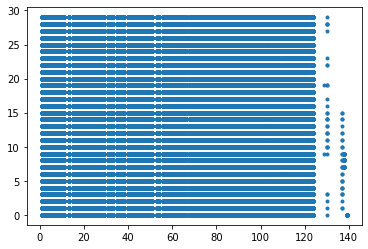

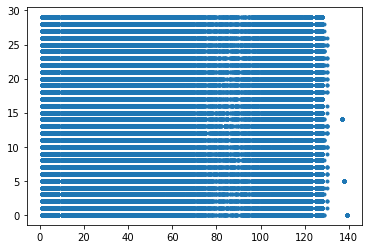

In [55]:
df0 = df.loc[df.FPGA==0]
ch0 = df0["TDC_CHANNEL"]
co0 = df0["TDC_MEAS"]
df1 = df.loc[df.FPGA==1]
ch1 = df1["TDC_CHANNEL"]
co1 = df1["TDC_MEAS"]
p0 = plt.figure()
plt.plot(ch0,co0,".")
p0.show()
p1 = plt.figure()
plt.plot(ch1,co1,".")
p1.show()



In [60]:
fpga = df.groupby(['FPGA'])
f0 = fpga.get_group(0)
f1 = fpga.get_group(1)
print(f0.sort_values(by='TDC_MEAS',ascending=False).head(3))
print(f1.sort_values(by='TDC_MEAS',ascending=False).head(3))

        HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
288243     1     0           46  3869203041         363        29
138340     1     0           61  3869201543        2808        29
289902     1     0           60  3869203058        1275        29
         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
243708      1     1            3  3869202592        1501        29
525358      1     1           52  3869205483         174        29
1025107     1     1            4  3869209197        2951        29


In [66]:
tdc_ch = df.groupby('TDC_CHANNEL')
tdc_ch_139 = tdc_ch.get_group(139)
tdc_ch_139['ORBIT_CNT'].value_counts


<bound method IndexOpsMixin.value_counts of 7          3869200167
15         3869200167
30         3869200167
39         3869200167
48         3869200168
              ...    
1310650    3869211170
1310660    3869211170
1310685    3869211170
1310701    3869211171
1310718    3869211171
Name: ORBIT_CNT, Length: 108059, dtype: int64>